* This notebook was made to look at the alongshore, cross-starit transport of fresh water, total water amount of each run.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '7':{'jst':36, 'ist':100,'jen':37,'ien':101},
            '5':{'jst':34, 'ist':94,'jen':36,'ien':95}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

(48.95, 49.4)

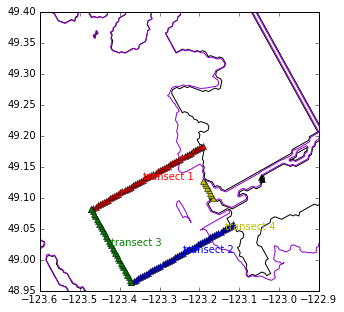

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.6,-122.9])
ax.set_ylim([48.95,49.4])

In [86]:
##confuse~
ugrid = U['Oct2014OnlyRiver'][-1,0,0:2,0:2]
u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
print (ugrid.shape)
print (u.shape)
print (u[..., 1:, :].shape)

(2, 2)
(2, 1)
(1, 1)


In [5]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat'] 

In [6]:
def transport_time (S,U,V,lon,lat,depU,depV,tran,string ='specific time',fresh_flag = False):
    """This subfunction was made only to calculate the 
       transport/freshwater transport of a transect at the specific time"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4': ## cross-shelf transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']-1).shape[0]])
                for z in np.arange(depU.shape[0]-1):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst']+j,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j,transects[tran]['ist']], \
                        lon[transects[tran]['jst']+j+1,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j+1,transects[tran]['ist']])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,j,0])/30
                        trans[pa][t][z,j] = U[pa][t][z,j,0]*d*1000*(depU[z+1]-depU[z])*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']-1).shape[0]]);
                for z in np.arange(depV.shape[0]-1):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst'],transects[tran]['ist']+i],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i], \
                        lon[transects[tran]['jst'],transects[tran]['ist']+i+1],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i+1])
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,0,i])/30
                        trans[pa][t][z,i] = V[pa][t][z,0,i]*d*1000*(depV[z+1]-depV[z])*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = {}; trans_total[pa] ={}
        for t in strings[string]:
            trans_surf[pa][t] = np.sum(trans[pa][t],axis = 1)[0]
            trans_total[pa][t] = np.sum(trans[pa][t])
 
    return trans, trans_surf,trans_total

In [7]:
def transport_calculate (S,U,V,lon,lat,depU,depV,tran,string ='specific time',\
                         fresh_flag = False,y0lim =6e5, y1lim = 6000):
    """ This function was made to calculate the total transport (False)
        or fresh water transport (True) in the entire water column at specific 
        time or averaged low/high tides along the north/south cross-strait
        transect or along-shore transect .
    """
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,2], height_ratios=[1, 1])  
    gs.update(hspace=0.15, wspace=0.15)
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    if string == 'specific time' or string =='current time':
        for pa in paths:
            UU[pa] = {}; VV[pa] = {}; SS[pa] = {}
        for t in strings[string]:
            for pa in paths:
                SS[pa][t] = S[pa][strings[string][t],:,jinds,iinds]
                u,v = viz_tools.unstagger(U[pa][strings[string][t],:,jinds,iinds],\
                                          V[pa][strings[string][t],:,jinds,iinds])
                #rotate
                theta = np.pi*29/180
                UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
                VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
        trans,trans_sur,trans_to = transport_time(SS,UU,VV,lon,lat,depU,depV,tran,string = string,\
                                                 fresh_flag = fresh_flag) ## get surface/total transport
        ## location
        ax = fig.add_subplot(gs[0,0])
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim([-123.6,-122.9])
        ax.set_ylim([48.95,49.4])
        if tran =='3' or tran =='4':
            ax.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],\
            Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],'ro')
        else:
            ax.plot(X[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],\
            Y[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],'ro')
        ax.annotate ('transect '+tran,(X[transects[tran]['jst'],transects[tran]['ist']],\
                    Y[transects[tran]['jst'],transects[tran]['ist']]), xycoords="data",color = 'r')
        ## total transport
        ax = fig.add_subplot(gs[0,1])
        cs = ['g','r','m','k','y']
        transurf = {}; trantotal = {} ## turn a dict to list
        for pa in paths:
            transurf[pa] = []; trantotal[pa] = [];
            transurf[pa] = [trans_sur[pa]['t_ind_low'],trans_sur[pa]['middle of flood'],trans_sur[pa]['t_ind_high']]
            trantotal[pa] = [trans_to[pa]['t_ind_low'],trans_to[pa]['middle of flood'],trans_to[pa]['t_ind_high']]
            
        for pa,c in zip(paths,cs):
            ax.plot(trantotal[pa],'-*',color = c,label = pa)
            print (pa,trantotal[pa])
        ax.set_ylim([-y0lim,y0lim])
        ## surface transport
        ax = fig.add_subplot(gs[1,1]) 
        for pa,c in zip(paths,cs):
            ax.plot(transurf[pa],'-.*',color = c,label = pa)
        ax.set_ylim([-y1lim,y1lim]) 
        for ax in [fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,1])]:
            ax.legend(loc = 'best')
            ax.grid('on')
            plt.setp(ax, xticks=[0, 1, 2], xticklabels=['low tide','middle of flood','high tide'])
            if fresh_flag == False:
                ax.set_ylabel('Total transport [m^3/s]')
            else:
                ax.set_ylabel('Fresh water transport [m^3/s]')
    return fig

In [8]:
def uv_contour(U,V,depU,depV,pa,tran,ind,string = 'specific time',st = 't_ind_high'):
    """This function was made to look at the u,v contour along transect"""
    fig,axs =plt.subplots(2,1,figsize = (12,6))
    UU = {}; VV= {};
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    UU[pa] = {}; VV[pa] = {};
    #for t in strings[string]:
    u,v = viz_tools.unstagger(U[pa][strings[string][st],:,jinds,iinds],\
                                          V[pa][strings[string][st],:,jinds,iinds])
    #rotate
    theta = np.pi*29/180
    UU[pa][st] = u*np.cos(theta) - v*np.sin(theta)
    VV[pa][st] = u*np.sin(theta) +v*np.cos(theta)
    if tran == '1' or tran =='2':
        islices = np.arange(transects[tran]['ien'] - transects[tran]['ist'])
        dep = depV
        VV[pa][st] = VV[pa][st][:,0,:]
        UU[pa][st] = UU[pa][st][:,0,:]
    else:
        islices = np.arange(transects[tran]['jen'] - transects[tran]['jst'])
        dep = depU
        UU[pa][st] = UU[pa][st][:,:,0]
        VV[pa][st] = VV[pa][st][:,:,0]
    for ax, ob in zip (axs, [UU[pa][st],VV[pa][st]]):
        mesh = ax.contourf(islices, dep[:], ob,np.arange(-0.5,0.5+0.1,0.1), cmap = 'bwr')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.set_ylim([dep[ind], 0])
        ax.set_xlim([islices[0],islices[-1]])

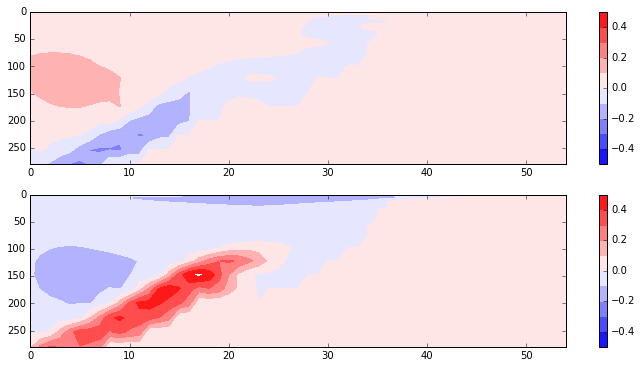

In [9]:
uv_contour(U,V,depU,depV,'Oct2014OnlyRiver','1',33)

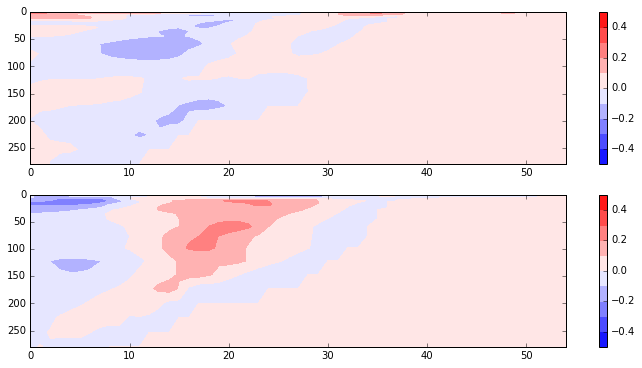

In [10]:
uv_contour(U,V,depU,depV,'Oct2014combineall','1',33)

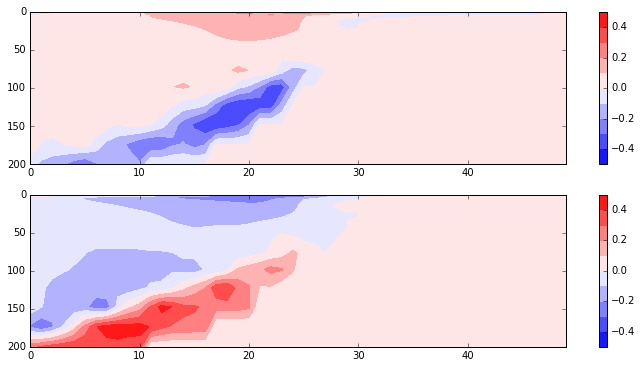

In [11]:
uv_contour(U,V,depU,depV,'Oct2014OnlyRiver','2',30)

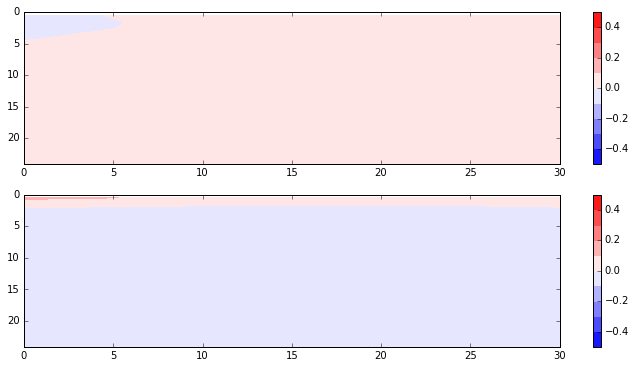

In [12]:
uv_contour(U,V,depU,depV,'Oct2014OnlyRiver','3',20)

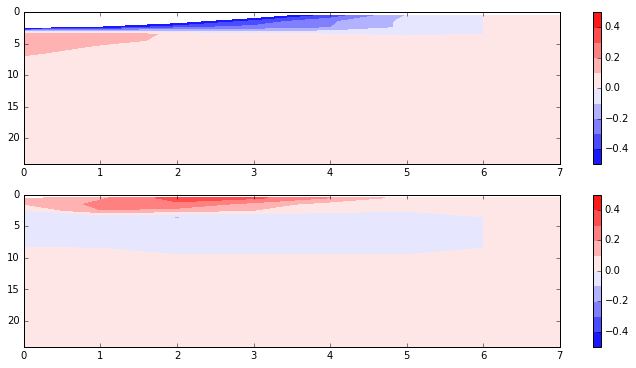

In [13]:
uv_contour(U,V,depU,depV,'Oct2014OnlyRiver','4',20)

# Total transport

Oct2014OnlyRiver [40101.345393949552, 39549.519879959284, 39339.272145345283]
Oct2014notides [21328.50017768806, 28391.518638807371, 26877.144426027196]
Oct2014nowind [-86556.927293547022, 569698.61355183239, 4034.8662526674043]
Oct2014nof [-119709.95251842134, 501958.76374983019, -160293.64975208198]
Oct2014combineall [-89252.049557118007, 583116.0723823345, 26735.775044871014]


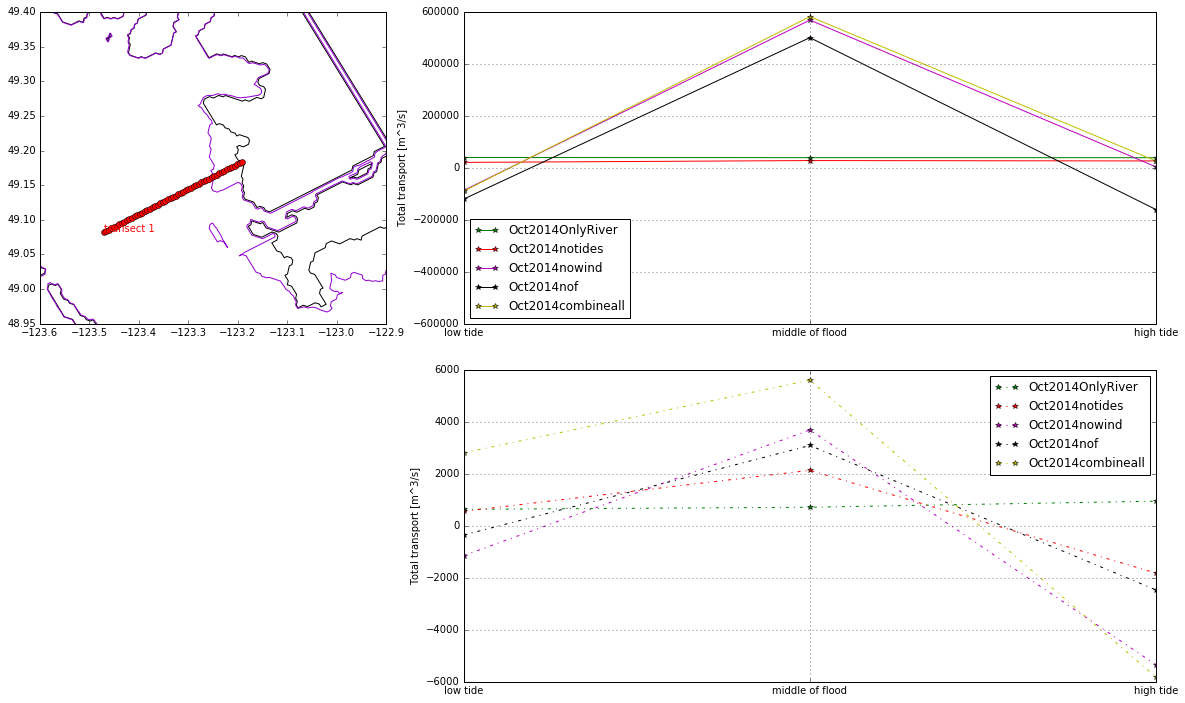

In [16]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'1',y0lim =6e5)

* Net total transport of onlyriver/notides is positive, due to the positive v velocity in the lower layer, with deeper resolution depth.

Oct2014OnlyRiver [9170.7897393923995, 8999.2157312046256, 8975.8120335319327]
Oct2014notides [50627.63554640775, 46789.517799957583, 42364.400049463227]
Oct2014nowind [-28324.027345205734, 543825.07286524912, 60941.828104248016]
Oct2014nof [-71589.487872148369, 471572.9355254228, -122006.32033723682]
Oct2014combineall [-27379.087015545359, 572370.23111991026, 99989.242391180014]


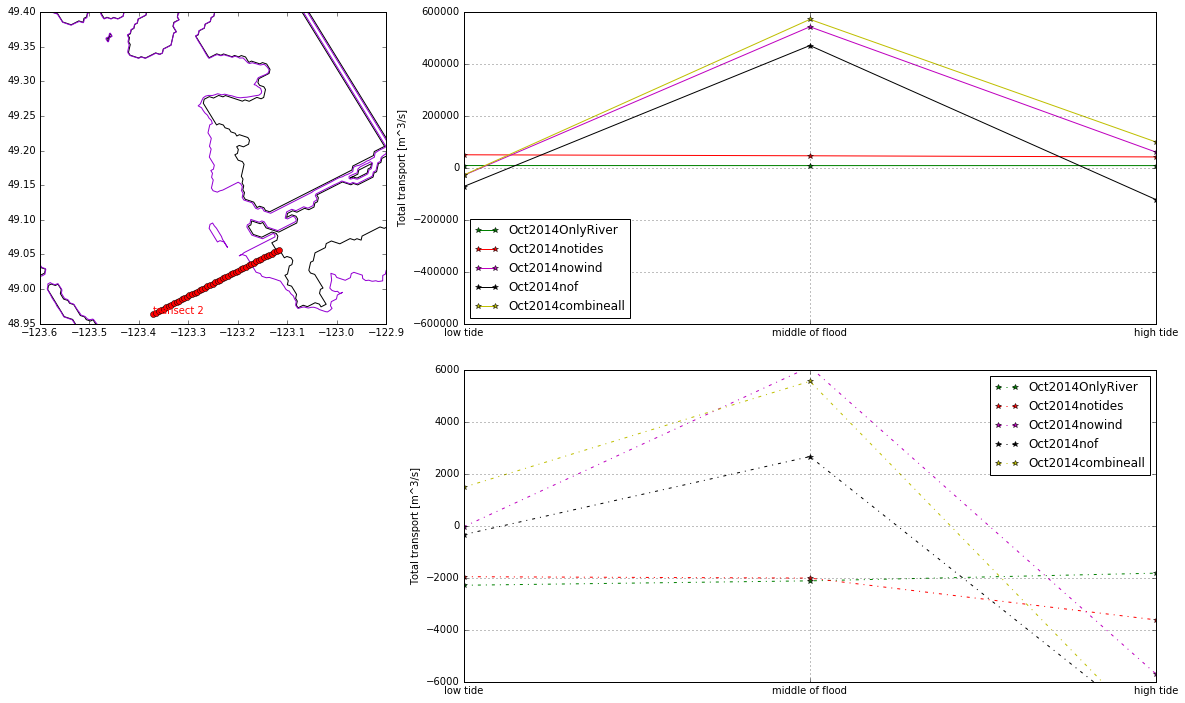

In [49]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'2')

Oct2014OnlyRiver [70079.889518773329, 70685.44283777861, 70766.867782687652]
Oct2014notides [70302.526797375001, 40577.324221158211, 37836.257809412593]
Oct2014nowind [81784.548069243654, -627655.95431295619, 221033.60042816162]
Oct2014nof [7754.3961164076973, -791043.12251214322, 7452.0431142434463]
Oct2014combineall [79105.040361861451, -643214.60528955329, 218549.12599914568]


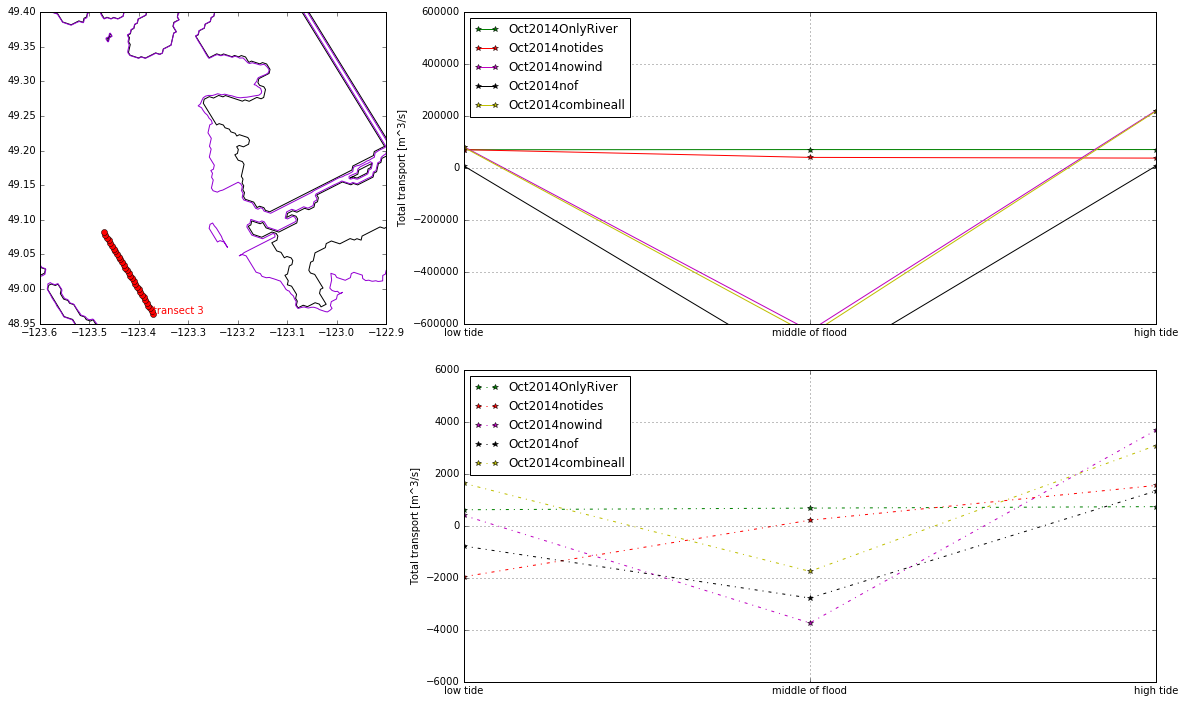

In [51]:
fig= transport_calculate(S,U,V,lon,lat,depU,depV,'3')

* No wind case does not affect much on the total water transport in the water column of the plume region, more important for downstream surface transport than upstream.
* Total transport at north/south transect of onlyriver/notide case is always upstream, with surface transport going north and south for each transect (north/south), respectively.

Oct2014OnlyRiver [-3172.7868682490916, -3117.6012631228668, -3154.658095345389]
Oct2014notides [-3567.0939319809995, -3513.8177778229465, -3321.5490277848758]
Oct2014nowind [-9851.6555626327354, 8541.2294271824903, -3056.6255949953047]
Oct2014nof [-9703.0679661480117, 9181.8961565803293, -2388.2692624507044]
Oct2014combineall [-9945.3583863608674, 8603.340804806805, -3175.3288341725756]


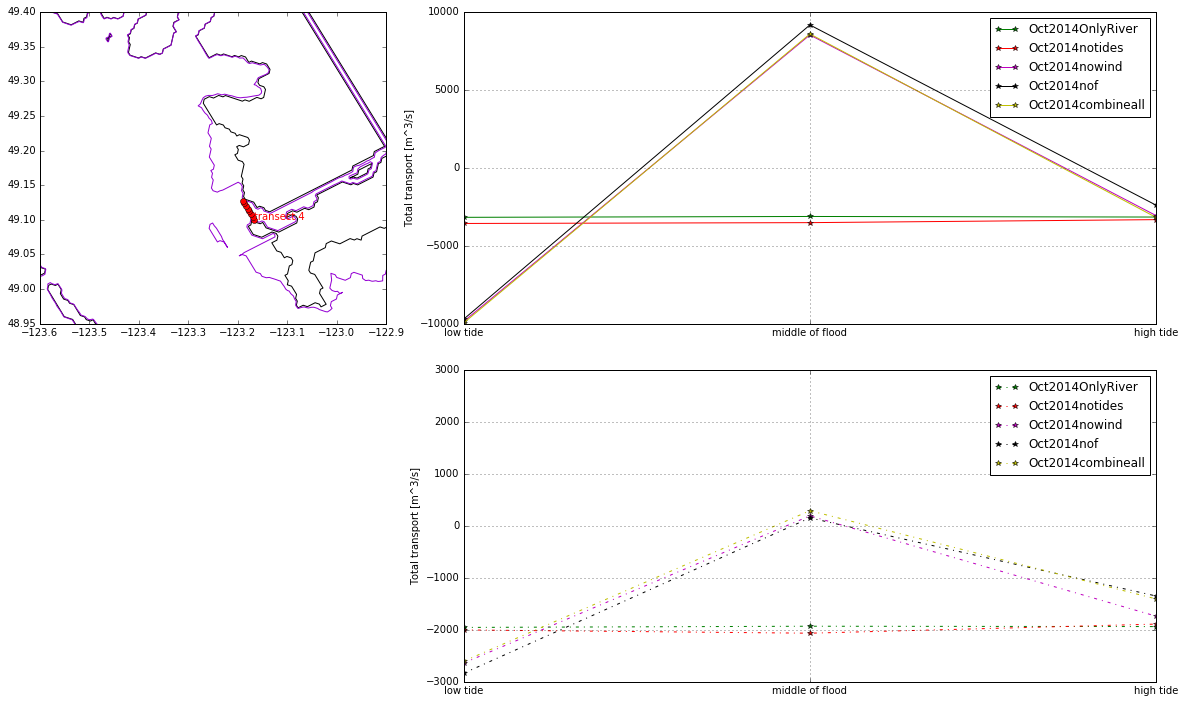

In [53]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'4',y0lim=1e4,y1lim=3e3)

# fresh water transport

Oct2014OnlyRiver [-12395.107033123046, -12255.538856803654, -12088.933062962686]
Oct2014notides [-14889.166576928463, -14376.246163112548, -18204.918637034407]
Oct2014nowind [-4849.6667268109659, 652.83076194739442, -6332.1503492968768]
Oct2014nof [-1902.7611931656652, -10547.476816724251, -4607.5046192507834]
Oct2014combineall [270.33392275072924, -1924.9819300158269, -7367.9291836565808]


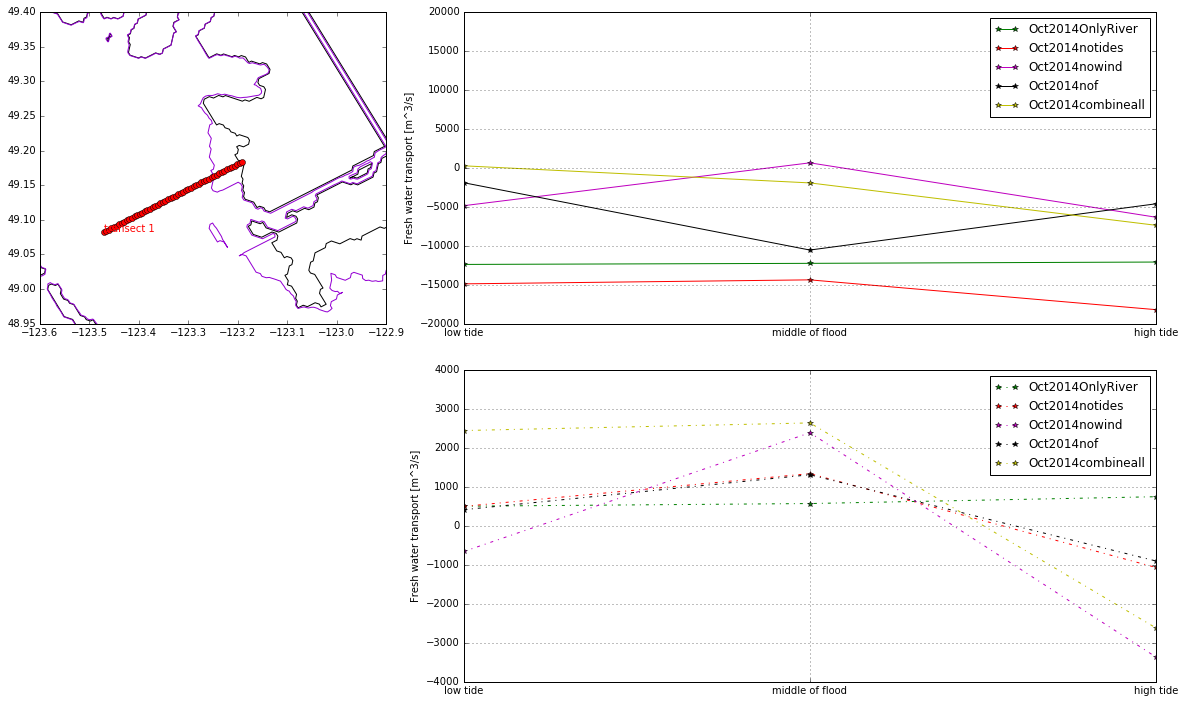

In [56]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'1',fresh_flag = True, y0lim =2e4,y1lim = 4e3)

In [13]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = np.loadtxt(filename)
fraserflow[378]

array([ 2014.   ,    10.   ,    31.   ,  2585.685])

Oct2014OnlyRiver [-9082.4202108625614, -8907.2551167930778, -8622.6054793415296]
Oct2014notides [-7876.1245905500282, -8634.5504045213384, -8353.7974964969471]
Oct2014nowind [-1463.919829700611, 4323.8855982214664, -6436.7728150009807]
Oct2014nof [-506.77399641726106, -4401.2140691956247, -9072.7684148172975]
Oct2014combineall [1923.767961437788, 417.9864387750722, -6312.4337596560308]


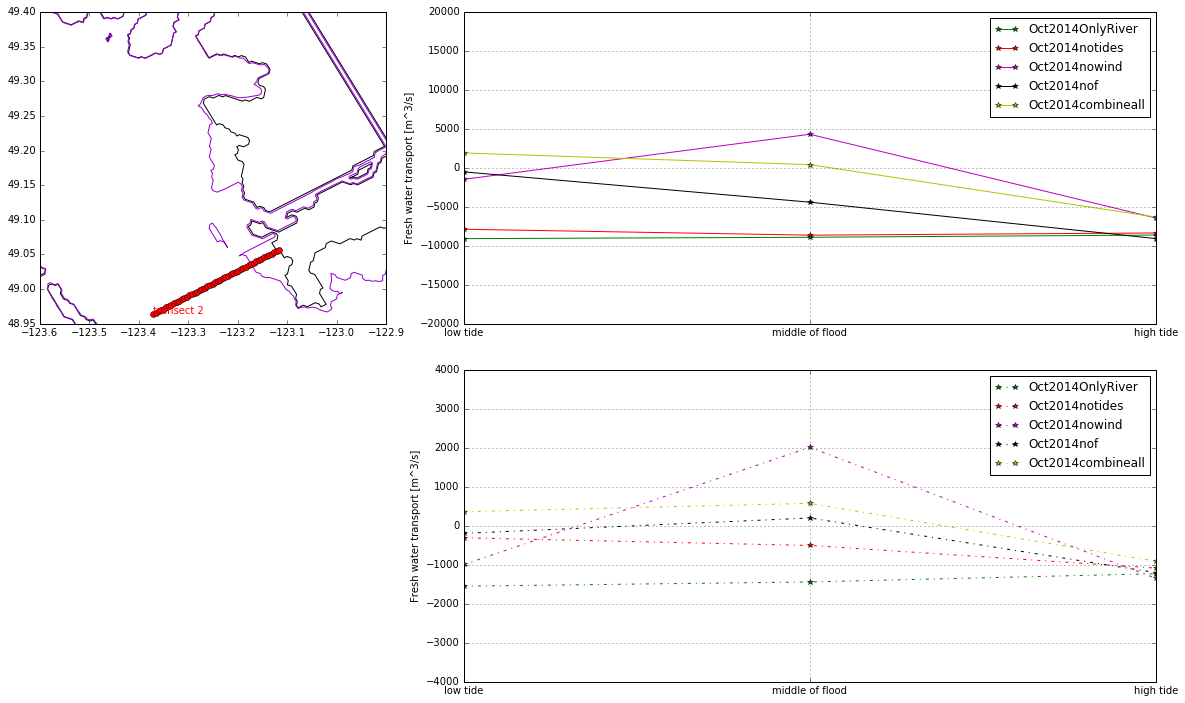

In [57]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'2',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [1812.3342274252491, 1741.3270114306138, 1711.0944413775753]
Oct2014notides [973.18908437533787, 2815.352117000059, 2629.5247051355186]
Oct2014nowind [852.86887829812565, 2664.5038612138414, 5309.809073026031]
Oct2014nof [2453.1732393849788, 15893.93705696721, 3614.5858290337956]
Oct2014combineall [1788.1758064400219, 7686.4080432040191, 2104.3778190011672]


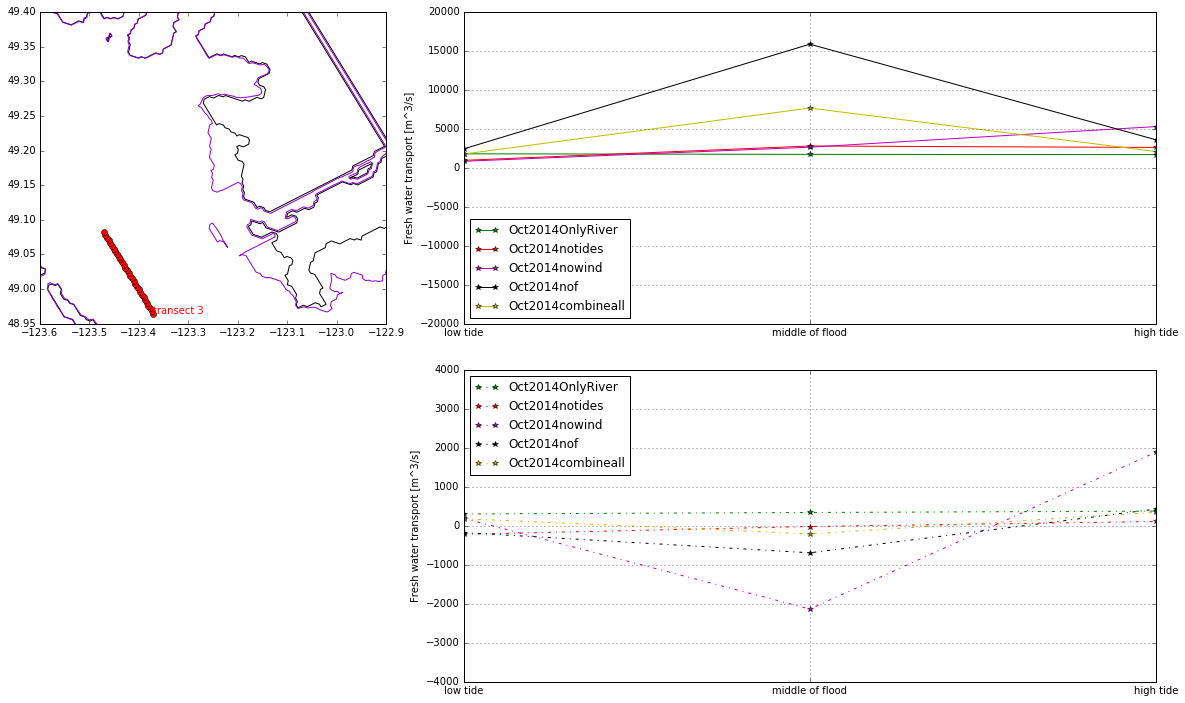

In [58]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'3',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [-3048.4931325402904, -3028.9447649020294, -3002.4009080334936]
Oct2014notides [-3096.3109551089324, -3188.0991916905969, -3031.8366748150929]
Oct2014nowind [-6584.2514423770217, 1489.2610231308445, -1882.8530044527281]
Oct2014nof [-6679.6241060792381, 1126.1677688340465, -1520.3113111017544]
Oct2014combineall [-7081.4210561484451, 2181.6786811338193, -1745.3695118585483]


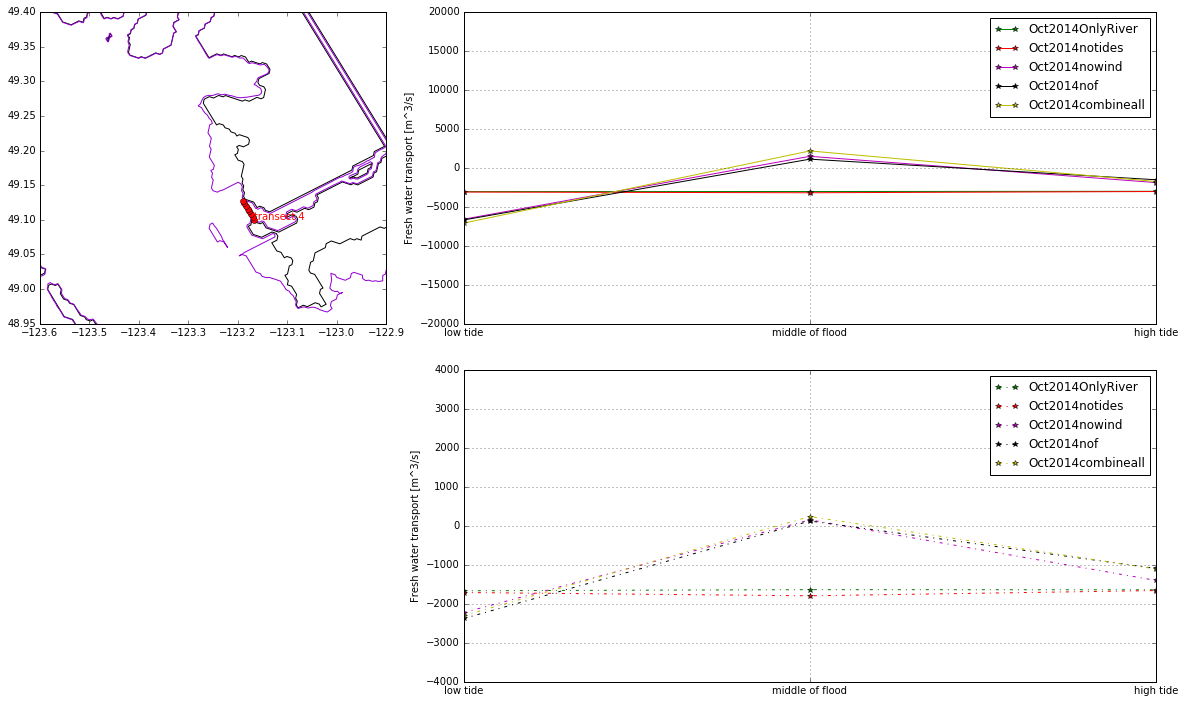

In [59]:
fig = transport_calculate(S,U,V,lon,lat,depU,depV,'4',fresh_flag = True,y0lim =2e4, y1lim = 4e3)